# Wise Sliding Window Segmentation: A classification-aided approach for trajectory segmentation

## Experiments on hurricane dataset

If you are using this code please cite the following paper:

@article{etemadwise,
  title={Wise Sliding Window Segmentation: A classification-aided approach for trajectory segmentation},
  author={Etemad, Mohammad and Etemad, Zahra and Soares, Am{\i}lcar and Bogorny, Vania and Matwin12, Stan and Torgo, Luis}
}
[The arxiv version of the paper is available here](https://arxiv.org/abs/2003.10248)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import numpy as np
from core.random_walk import random_walk
from core.linear import linear
from core.cubic import cubic
from core.kinematic import kinematic
interpolations = [random_walk, cubic, linear, kinematic]
interpolation_names = ['Random Walk', 'cubic', 'linear', 'kinematic']
window_size=7
listoffiles=['./db/hurricane/h_d10.txt'
            ,'./db/hurricane/h_d1.txt'
            ,'./db/hurricane/h_d2.txt'
            ,'./db/hurricane/h_d3.txt'
            ,'./db/hurricane/h_d4.txt'
            ,'./db/hurricane/h_d5.txt'
            ,'./db/hurricane/h_d6.txt'
            ,'./db/hurricane/h_d7.txt'
            ,'./db/hurricane/h_d8.txt'
            ,'./db/hurricane/h_d9.txt']


def clean_df(df_test,window_size):
    # remove all segments shorter than windows_size+1
    
    dic={}
    l=[]
    dfff=df_test.copy()
    for i in set(df_test.tsid):
        if df_test.iloc[np.where(np.array(df_test.tsid)==i)[0],:].shape[0]<=window_size+1:
            dic[i]=df_test.iloc[np.where(np.array(df_test.tsid)==i)[0],:].shape[0]
            l.append(i)
    df_test=df_test[~df_test.tsid.isin(l)].copy()
    return df_test

def purity( ground_truth, labels):
    #ground_truth=label
    avg = []
    ground_truth = np.array(ground_truth)
    labels = np.array(labels)

    for ts in set(labels):
        ma = 0
        g = ground_truth[(np.where(labels == ts)[0])]
        for tp in set(g):
            _ = len(np.where(g == tp)[0])
            if _ > ma:
                ma = _
        # do not involve noise
        if ts != -1:
            #print(ma,len(g),str(ma * 1.0 / len(g)))
            avg.append(ma * 1.0 / len(g))
    return avg, np.mean(np.array(avg))

def coverage( ground_truth, labels):
    #ground_truth=tsid
    cov = []
    labels = np.array(labels)
    ground_truth = np.array(ground_truth)

    for ts in set(ground_truth):
        mx = 0
        g = labels[(np.where(ground_truth == ts)[0])]
        for l in set(g):
            _ = len(np.where(g == l)[0])
            if mx<=_:
                mx=_
        cov.append(mx * 1.0 / len(g))
    return cov, np.mean(np.array(cov))

def read_fold(file_name,new_columns_names):
    df1 = pd.read_csv(file_name, sep=';', parse_dates=['time'])
    df1 = df1.sort_index()
    df1.rename(columns=new_columns_names, inplace=True)
    tsid_ = df1.sid * 10000 + df1.tid
    df_fold1 = df1.assign(tsid=tsid_)
    df_fold1.sort_values(by=['tsid', 'time'], inplace=True)
    return df_fold1.copy()
def calculate_error(df, f1=None, rang=(0, 0), window_size=7):
    start = rang[0]
    if rang[1] == 0:
        limit = df.shape[0]
    else:
        limit = rang[1]
    end = limit
    ln=int(window_size/2)
    da=[0]*ln
    print(window_size,"dd",da)
    for ix in range(end - start - window_size):
        try:
            seven_points = df.iloc[start + ix:start + ix + window_size, :]
            lat = seven_points.lat.values
            lon = seven_points.lon.values
            p1, p2, pc, d = f1(seven_points)
        except:
            d = 0
        da.append(d)
        
    for i in range(ln+1):
        da.append(0)
    print(window_size,"dd",da[-10:])
    return da

def generate_error_signal( df,window_size, interpolation_name='Random Walk'):

    f = interpolation_names.index(interpolation_name)
    res = {}
    means_res = {}

    da = calculate_error(df, f1=interpolations[f], rang=(0, 0),window_size=window_size)
    res[interpolation_names[f]] = da
    means_res[interpolation_names[f]] = np.nanmax(da)
    da[0:int(window_size/2)]=[da[int(window_size/2)]]*int(window_size/2)
    da[len(da)-1*int(window_size/2)-1:len(da)]=[da[len(da)-int(window_size/2)-2]]*(int(window_size/2)+1)

    return da

def signal_to_sample(e_signal,sid,window_size=7):
    r=[]
    X_train=[]
    y_train=[]
    for i in range(0,len(e_signal)-window_size):
        r.append([e_signal[i:i+window_size],np.sign(len(set(sid[i:i+window_size]))-1)])
        X_train.append(e_signal[i:i+window_size])
        y_train.append([np.sign(len(set(sid[i:i+window_size]))-1)])
    y_train=pd.DataFrame(y_train)
    X_train=pd.DataFrame(X_train)
    return X_train,np.array( y_train).ravel()

def check_traj(a,label,verbose=False):
    bad=0
    x=a[0]
    start=0
    j=0
    for i in range(len(a)):
        if x==a[i]:
            pass
        else:
            if verbose:
                print("[",start,",",i,"]",i-start,label[start])
            if i-start<=window_size:
                if verbose:
                    print("***")
                bad=bad+i-start
                j=j+1
            x=a[i]
            start=i+1
    if verbose:
        print("[",start,",",len(a),"]",len(a)-start,label[start])
    print("***:",j)
    print("quality:",int((len(a)-bad)/len(a)*100))
    

def majority_vote(res,window_size=7,degree=0.9):
    start=0
    segid=1
    nsegid=-1
    segmentid=[]
    for i in range(int(window_size/2)+1,len(res)-int(window_size/2)):
         if(np.sum(res[i-int(window_size/2):i+int(window_size/2)+1])>=int(window_size*degree)):
            
            if i-start<=window_size:

                segmentid=segmentid+[nsegid]*(i-start)
                nsegid=nsegid-1
                start=i
      
            else:
                segmentid=segmentid+[segid]*(i-start+1)
                segid=segid+1
                start=i+1

    segmentid=segmentid+[segid]*(len(res)-start)
    return np.array(segmentid)

In [2]:
def experiment(window_size,degree=0.9):
    j=0 #train file id
    rang=set(range(len(listoffiles)))
    hmm=[]
    pmm=[]
    cmm=[]
    for i in rang:
        train_file=listoffiles[j] 
        print(i,j, "train file:",train_file)
        df=read_fold(file_name=train_file,new_columns_names={'latitude': 'lat','longitude': 'lon'})
        df=clean_df(df,window_size) #clean short segments
        a=np.array(df.tsid)
        l=df.label
        check_traj(a,l)
        print("length of training data:",df.shape)
        e_signal=generate_error_signal( df,window_size)
        print("length of error signal:",len(e_signal))

        X_train, y_train=signal_to_sample(e_signal=e_signal,sid=df.tsid,window_size=window_size)
        print(X_train.shape,y_train.shape)

        rf=RandomForestClassifier( n_estimators=100)
        rf.fit(X_train, y_train)
        acc=[]
        hm=[]
        pm=[]
        cm=[]
        for k in rang-set([j]):
            test_file=listoffiles[k]
            df_test=read_fold(file_name=test_file,new_columns_names={'latitude': 'lat','longitude': 'lon'})
            df_test=clean_df(df_test,window_size) #clean short segments

            e_signal_test=generate_error_signal( df_test,window_size)
            X_test, y_test=signal_to_sample(e_signal=e_signal_test,sid=df_test.tsid,window_size=window_size)

            y_pred=rf.predict(X_test)
            y_pred=np.array(list([y_pred[0]]*int(window_size/2))+list(y_pred)+list([y_pred[-1]]*(int(window_size/2)+1)))
            score = rf.score(X_test, y_test)
            acc.append(int(100*score))

            segmentid=majority_vote(y_pred,window_size=window_size,degree=degree)
            
            pur=purity(ground_truth=df_test.label,labels=segmentid)[1]
            cov=coverage(ground_truth=df_test.tsid,labels=segmentid)[1]
            #print("\tPurity:",pur)
            #print("\tCoverage:",cov)
            h=2*pur*cov/(pur+cov)
            hm.append(100*h)
            pm.append(100*pur)
            cm.append(100*cov)
            print("\tHarmonic mean:",h)
            #print(list(zip(segmentid,df_test.tsid)))
        print("\t",k, "harmonic mean avg:",np.mean(hm),hm)
        print("\t",k, "Accuracy of Binary classifier:",acc)
        j=j+1
        hmm.append(np.mean(hm))
        pmm.append(np.mean(pm))
        cmm.append(np.mean(cm))
    print(np.mean(hmm),np.std(hmm),hmm)
    return hmm,np.mean(hmm),np.std(hmm),pmm,np.mean(pmm),np.std(pmm),cmm,np.mean(cmm),np.std(cmm)

In [3]:
parameters={'window_sizes':[5,7,9,11,13],'degree':[0.6,0.9]}
res={}
pres={}
cres={}
res_mean={}
res_std={}
for d in parameters['degree']:
    for ws in parameters['window_sizes']:
        print(d,ws)
        hmm,hmm_mean,hmm_std,pmm,pmm_mean,pmm_std,cmm,cmm_mean,cmm_std=experiment(ws,d)
        res[d,ws]=hmm
        pres[d,ws]=pmm
        cres[d,ws]=cmm
        res_mean[d,ws]=hmm_mean
        res_std[d,ws]=hmm_std
print("done")

0.6 5
0 0 train file: ./db/hurricane/h_d10.txt
***: 3
quality: 92
length of training data: (255, 12)
5 dd [0, 0]
5 dd [611463.4264718624, 1499354.4804895557, 467356.76448779844, 393258.7984159876, 24031.110362104388, 29074.980649702946, 17310.08921027699, 0, 0, 0]
length of error signal: 255
(250, 5) (250,)
5 dd [0, 0]
5 dd [30890.752391123835, 48026.76440019746, 32092.25859420757, 84545.34308358142, 49489.665432655114, 72972.54280148323, 28560.907662530975, 0, 0, 0]
	Harmonic mean: 0.9062885918127156
5 dd [0, 0]
5 dd [325411.3241685771, 239505.6874393703, 27519.01523143784, 41633.23382882155, 38943.84597570531, 28880.126147060477, 52660.40961782792, 0, 0, 0]
	Harmonic mean: 0.9511635910917593
5 dd [0, 0]
5 dd [3859725.173884439, 755704.5432238781, 115432.3025848572, 92072.27036938423, 131753.11010701815, 384675.87010425644, 70507.193006954, 0, 0, 0]
	Harmonic mean: 0.9419773599509527
5 dd [0, 0]
5 dd [118394.65497007141, 531944.2503495464, 2084347.462267364, 258034.70515321067, 357075

5 dd [65012.42566818705, 52805.239164930135, 79759.07609700799, 19236.927713325724, 39648.711275366375, 53096.2968226732, 65757.13107653389, 0, 0, 0]
	Harmonic mean: 0.9331945130483724
5 dd [0, 0]
5 dd [975629.6298396124, 3129029.018984426, 263140.8673498931, 650287.706652745, 25871.515417347262, 53944.51663322756, 13248.88458975501, 0, 0, 0]
	Harmonic mean: 0.8737236566163578
5 dd [0, 0]
5 dd [154089.84441835454, 98750.31216861667, 174005.58321155887, 29387.630228211325, 40408.92141227204, 332457.3657245733, 320785.30008832907, 0, 0, 0]
	Harmonic mean: 0.9452444998758078
5 dd [0, 0]
5 dd [275.5016747335628, 5296.456473575396, 3788.4535744735595, 4136.899355053002, 7887.682880017579, 28576.478749966223, 16949.433299754288, 0, 0, 0]
	Harmonic mean: 0.9387833587719803
5 dd [0, 0]
5 dd [34600.24013536074, 18513.043569394416, 113314.65089280455, 34730.94446093628, 29898.512143077813, 92065.90562899243, 47503.61370739371, 0, 0, 0]
	Harmonic mean: 0.9135584366244004
	 9 harmonic mean avg: 92

5 dd [147849.725467775, 133058.89119059002, 45298.077779797604, 93066.58941813602, 58532.28702180819, 131060.8764812517, 68970.67918920491, 0, 0, 0]
length of error signal: 168
(163, 5) (163,)
5 dd [0, 0]
5 dd [1210715.7439455513, 2054513.5120881991, 1103291.6308559852, 1582864.7642536033, 12968.936104105467, 1909.8090399960852, 24604.205978388665, 0, 0, 0]
	Harmonic mean: 0.910547823718938
5 dd [0, 0]
5 dd [25174.25998424471, 18216.500117817362, 3618.367275310373, 48007.52253869031, 34109.39856241633, 34334.469495659134, 21072.95887958932, 0, 0, 0]
	Harmonic mean: 0.9132142813015948
5 dd [0, 0]
5 dd [345969.853884023, 187398.2703503133, 249155.7382195769, 25328.245174043863, 36138.336477624915, 42016.3765675144, 54902.71488774776, 0, 0, 0]
	Harmonic mean: 0.9262384900117028
5 dd [0, 0]
5 dd [81574.84638037218, 6067655.815387796, 14634.329823469736, 22589.945042673546, 217525.6588772682, 157940.7624874552, 132478.72101252238, 0, 0, 0]
	Harmonic mean: 0.9274075362999253
5 dd [0, 0]
5 dd

	Harmonic mean: 0.8175574798447298
7 dd [0, 0, 0]
7 dd [26497.687103740678, 33685.62040479731, 174079.3414253605, 51733.069406603245, 126083.68705887125, 63772.55799427656, 0, 0, 0, 0]
	Harmonic mean: 0.8948331053062009
7 dd [0, 0, 0]
7 dd [61817.35248064638, 7690.514022338383, 26592.511859977323, 26972.955932105164, 19357.52598535349, 111475.68618005888, 0, 0, 0, 0]
	Harmonic mean: 0.7705010320885721
7 dd [0, 0, 0]
7 dd [56638.6509676308, 233702.70168252915, 114796.072310253, 193665.5988937673, 434435.20647120796, 375878.4422929074, 0, 0, 0, 0]
	Harmonic mean: 0.7744304574762052
7 dd [0, 0, 0]
7 dd [5613.827483248651, 3535.2237839726836, 6536.959763891769, 7653.600353808433, 19256.386286422527, 48456.41901284546, 0, 0, 0, 0]
	Harmonic mean: 0.8014084631583237
7 dd [0, 0, 0]
7 dd [116007.61058984125, 130221.87943004837, 50144.54403206669, 76792.05553614677, 77433.75451646838, 39038.874255524, 0, 0, 0, 0]
	Harmonic mean: 0.9498000331268001
	 9 harmonic mean avg: 83.79271911376783 [82.47

7 dd [0, 0, 0]
7 dd [50855.437317626864, 8430.458243835263, 4845.865067618157, 20204.060995535925, 21405.738382007563, 13117.256183110101, 0, 0, 0, 0]
	Harmonic mean: 0.8561659000075409
7 dd [0, 0, 0]
7 dd [40518.177310996274, 18966.539660535487, 118420.04396172141, 12908.241450577372, 43745.86955496823, 25057.204963982113, 0, 0, 0, 0]
	Harmonic mean: 0.7739130084536086
7 dd [0, 0, 0]
7 dd [148021.77151098475, 225333.50962685802, 277090.68354284595, 22710.65338816391, 100190.65678970666, 47426.72882549527, 0, 0, 0, 0]
	Harmonic mean: 0.7913947750697503
7 dd [0, 0, 0]
7 dd [4865186.660539939, 232807.6779083949, 3558142.411238316, 201787.03340094205, 153469.73340554093, 557485.7835733934, 0, 0, 0, 0]
	Harmonic mean: 0.8243385667420423
7 dd [0, 0, 0]
7 dd [94235.0350940777, 13408.35661443697, 80208.24170553518, 54728.255652040054, 141426.21736071983, 33159.84045613804, 0, 0, 0, 0]
	Harmonic mean: 0.8746146906561506
7 dd [0, 0, 0]
7 dd [109481.57168916303, 49869.403591808375, 28158.7907042

7 dd [1384.9200649722027, 1553.0350447159192, 4858.2773481975955, 8730.215246213906, 7769.736412907298, 46689.92366133811, 0, 0, 0, 0]
length of error signal: 198
(191, 7) (191,)
7 dd [0, 0, 0]
7 dd [280944.9659015896, 8191.729085406882, 1988.9928679506022, 11278.831128582593, 7618.29004952972, 22360.69680224694, 0, 0, 0, 0]
	Harmonic mean: 0.9142640541960436
7 dd [0, 0, 0]
7 dd [34243.3510964512, 22735.065125589448, 135133.94215903396, 41972.81674288471, 25960.60335398085, 130762.25134320953, 0, 0, 0, 0]
	Harmonic mean: 0.8547612739896429
7 dd [0, 0, 0]
7 dd [72545.27073103529, 90036.65029130878, 33475.489271539096, 142579.77297134878, 30581.016948552766, 42162.15053097616, 0, 0, 0, 0]
	Harmonic mean: 0.8441085372332429
7 dd [0, 0, 0]
7 dd [4036470.243279989, 2828209.2154749585, 3575461.3355415943, 165050.66015612503, 379638.72300831776, 97258.7231757167, 0, 0, 0, 0]
	Harmonic mean: 0.8646639063968922
7 dd [0, 0, 0]
7 dd [1673871.3685751248, 2422243.7389797964, 108151.1733948605, 8520

***: 0
quality: 100
length of training data: (169, 12)
9 dd [0, 0, 0, 0]
9 dd [346097.40042145026, 340425.4623669176, 43592.999980978544, 269308.0759359327, 247554.18847236596, 0, 0, 0, 0, 0]
length of error signal: 169
(160, 9) (160,)
9 dd [0, 0, 0, 0]
9 dd [71242.63738186847, 195625.9768875401, 7344.815553743026, 5128.8747003943645, 9046.321969762688, 0, 0, 0, 0, 0]
	Harmonic mean: 0.859232747551989
9 dd [0, 0, 0, 0]
9 dd [20029.938865316173, 34347.91453208603, 189084.6178303712, 138568.73143510384, 56814.87043408956, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8672916096483718
9 dd [0, 0, 0, 0]
9 dd [4112.859898746064, 51764.95183163126, 15584.635743849141, 12645.044693548964, 45956.74280845361, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8892579691366566
9 dd [0, 0, 0, 0]
9 dd [4480985.534237685, 73963.31125123463, 1114671.230669864, 123877.1252879468, 35886.773658800994, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8078273958855996
9 dd [0, 0, 0, 0]
9 dd [51025.49385635183, 20528.519391386777, 79711.15729831305, 1

(86, 9) (86,)
9 dd [0, 0, 0, 0]
9 dd [167566.27674455996, 97915.2307373144, 9336.176700258746, 2298.98674993139, 4995.478375899362, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8348114101210172
9 dd [0, 0, 0, 0]
9 dd [45829.333587182926, 158429.80679404485, 94402.9659969572, 46380.483356692275, 273404.00341870403, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8182446545896471
9 dd [0, 0, 0, 0]
9 dd [322643.1668415307, 337288.24300056056, 208302.73005861582, 16992.699903700985, 163919.43099379307, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8100531783490008
9 dd [0, 0, 0, 0]
9 dd [4586.121283301306, 28512.741941790166, 26215.460767570497, 20673.393675399682, 35971.78185982484, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8232996850246633
9 dd [0, 0, 0, 0]
9 dd [2912430.880595371, 202957.21836034197, 1806622.1540835456, 83844.21489218295, 112327.72832855776, 0, 0, 0, 0, 0]
	Harmonic mean: 0.833578792341679
9 dd [0, 0, 0, 0]
9 dd [64041.00634020361, 84814.32151598614, 58840.39179598054, 53261.521021612556, 146393.40927946777, 0, 0, 0, 

11 dd [134433.08068893867, 289006.10614113027, 301452.9294639304, 272430.00674559874, 0, 0, 0, 0, 0, 0]
length of error signal: 190
(179, 11) (179,)
11 dd [0, 0, 0, 0, 0]
11 dd [58994.3280397532, 62103.85340770178, 59455.457846610145, 354329.43055734725, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.5445870007222032
11 dd [0, 0, 0, 0, 0]
11 dd [73830.15846085323, 185943.3293301093, 332538.98068252107, 285093.49439527135, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7074136859593574
11 dd [0, 0, 0, 0, 0]
11 dd [35814.448036429465, 17688.3592337223, 26733.30897741373, 68776.8198368669, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.868268555680139
11 dd [0, 0, 0, 0, 0]
11 dd [50154.76781436949, 104469.72298002378, 71945.90139341423, 156344.72582711725, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 1.0
11 dd [0, 0, 0, 0, 0]
11 dd [31078.404694187266, 109576.7332169677, 63613.86863065474, 58036.26755725578, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8199244067842474
11 dd [0, 0, 0, 0, 0]
11 dd [17375.903372498535, 23249.134699072336, 773

11 dd [0, 0, 0, 0, 0]
11 dd [549056.6535404689, 359670.25988394185, 320014.9910581277, 354362.8278366138, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.736
11 dd [0, 0, 0, 0, 0]
11 dd [27400.22293322625, 42675.58145456052, 35823.875679647834, 64072.95876680202, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8225108225108225
11 dd [0, 0, 0, 0, 0]
11 dd [122196.65225383907, 77701.9593472921, 149491.65294833496, 177022.4079734064, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7111111111111111
11 dd [0, 0, 0, 0, 0]
11 dd [89966.86793322903, 212303.0243877231, 87774.10990068251, 117877.38851610811, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7971014492753623
11 dd [0, 0, 0, 0, 0]
11 dd [122794.87738331014, 81752.93251534567, 419385.84244510677, 341294.00629033503, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7807017543859649
11 dd [0, 0, 0, 0, 0]
11 dd [8711.80702539387, 11402.926456058098, 17390.244795036066, 33085.16796107984, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7913669064748202
11 dd [0, 0, 0, 0, 0]
11 dd [704717.6749090372, 160276.01

11 dd [69595.01410307149, 45035.151089287014, 125814.77319323161, 20552.508954348308, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8370634405094787
11 dd [0, 0, 0, 0, 0]
11 dd [96668.13821414462, 73890.45176193966, 100422.13387433154, 97012.704891347, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.5836575875486382
11 dd [0, 0, 0, 0, 0]
11 dd [533878.7391509321, 230542.62699838172, 523673.18783765973, 786307.1935259713, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7897673784023467
11 dd [0, 0, 0, 0, 0]
11 dd [126431.85685439545, 151537.3988310299, 47935.85826756542, 194371.331987044, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7319628823868934
	 9 harmonic mean avg: 76.25402204177932 [86.47165253660725, 62.42013434182772, 72.70024855426351, 82.94903405857967, 87.50000000000001, 83.70634405094786, 58.36575875486382, 78.97673784023466, 73.19628823868935]
	 9 Accuracy of Binary classifier: [92, 88, 92, 93, 88, 77, 80, 90, 76]
9 9 train file: ./db/hurricane/h_d9.txt
***: 0
quality: 100
length of training data: (74, 12)
11 dd [

13 dd [86862.16764559007, 117814.81986308628, 68753.05069489338, 0, 0, 0, 0, 0, 0, 0]
length of error signal: 136
(123, 13) (123,)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [183936.1382352073, 484908.7497989805, 117243.96860512979, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8930410475209651
13 dd [0, 0, 0, 0, 0, 0]
13 dd [111139.17371505854, 132214.1131889881, 106174.15362466943, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.6629039599453801
13 dd [0, 0, 0, 0, 0, 0]
13 dd [176807.93172202932, 228148.60435848765, 396712.0970045036, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.6790855207451314
13 dd [0, 0, 0, 0, 0, 0]
13 dd [154891.6065541093, 81184.50380292458, 197568.08038111893, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 1.0
13 dd [0, 0, 0, 0, 0, 0]
13 dd [2086370.0379126503, 166203.8898868367, 62945.61953303647, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7651141429359377
13 dd [0, 0, 0, 0, 0, 0]
13 dd [73122.34305959496, 82010.5802506374, 216639.44964761412, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7647058823529412
13 dd [

13 dd [0, 0, 0, 0, 0, 0]
13 dd [19342.2719334321, 22618.966202338863, 1002.3231652521633, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7764290443610682
13 dd [0, 0, 0, 0, 0, 0]
13 dd [54044.74454671038, 74805.36478814701, 111503.16907976817, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9284778385216644
	 9 harmonic mean avg: 85.10852495168015 [91.38983805809947, 81.45597374297166, 72.0852764823451, 85.86827296504715, 100.0, 86.13245816091487, 78.55421686746989, 77.64290443610682, 92.84778385216644]
	 9 Accuracy of Binary classifier: [86, 89, 89, 94, 100, 83, 94, 87, 78]
8 8 train file: ./db/hurricane/h_d8.txt
***: 0
quality: 100
length of training data: (154, 12)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [36772.98977027946, 24137.7809858838, 32673.302026077203, 0, 0, 0, 0, 0, 0, 0]
length of error signal: 154
(141, 13) (141,)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [215611.09057207248, 79453.51108467573, 132753.65669937737, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9387432469600047
13 dd [0, 0, 0, 0, 0, 0]
13 dd [134490

5 dd [139703.58215637287, 72281.65404914066, 74833.2011710946, 44630.43574193126, 29615.8346895176, 361546.819949608, 412634.8497365063, 0, 0, 0]
	Harmonic mean: 0.9879518072289156
5 dd [0, 0]
5 dd [303.1258308573754, 1382.724882723347, 6465.2050081921, 2770.4194558438357, 7070.435559230686, 4000.630581728544, 32983.09495653564, 0, 0, 0]
	Harmonic mean: 0.9661823043373441
5 dd [0, 0]
5 dd [51335.15844303031, 85962.5385232542, 37840.942931103986, 41426.061442070895, 17495.02122889971, 65743.9213654735, 41472.532515832754, 0, 0, 0]
	Harmonic mean: 0.9532710280373832
	 9 harmonic mean avg: 96.63903410556068 [94.27312775330397, 98.060900980609, 98.13504823151126, 96.12415130940835, 93.33499590750974, 99.08256880733946, 98.79518072289156, 96.61823043373441, 95.32710280373831]
	 9 Accuracy of Binary classifier: [96, 97, 97, 96, 94, 96, 95, 94, 94]
2 2 train file: ./db/hurricane/h_d2.txt
***: 0
quality: 100
length of training data: (198, 12)
5 dd [0, 0]
5 dd [296391.7786503127, 120687.2297026

5 dd [46920.02116861915, 20633.44586120739, 35471.21843328818, 46321.17141409791, 35270.883584898176, 34908.39579199671, 58670.11111086626, 0, 0, 0]
	Harmonic mean: 0.9906103286384975
5 dd [0, 0]
5 dd [338647.3257214372, 86476.86686928602, 165673.4805136208, 20821.98457044418, 35196.83824560423, 15299.427377438573, 48921.90418981289, 0, 0, 0]
	Harmonic mean: 0.9971509971509972
5 dd [0, 0]
5 dd [2790814.972274656, 4465040.137743857, 208649.43888294467, 82262.67131008983, 102308.46780472822, 192817.38425203876, 118864.16778981037, 0, 0, 0]
	Harmonic mean: 0.989667049368542
5 dd [0, 0]
5 dd [100456.4840622592, 1669147.6507840238, 3860797.8110471386, 873355.7724221253, 503340.92438780516, 12763.608360355192, 13876.37323443697, 0, 0, 0]
	Harmonic mean: 0.9755169954837176
5 dd [0, 0]
5 dd [1694270.704054529, 5853825.954493569, 745479.372023067, 1361448.5222600102, 70467.42690132871, 21127.598888250108, 25247.10549491699, 0, 0, 0]
	Harmonic mean: 0.9617711105734335
5 dd [0, 0]
5 dd [170635.48

5 dd [58827.434662488355, 75263.1362396314, 114305.82191236549, 48645.25360560911, 31219.27807294328, 77684.2562257566, 404677.6168700386, 0, 0, 0]
	Harmonic mean: 0.992
5 dd [0, 0]
5 dd [71236.63361830503, 47069.1097931964, 64589.15322253871, 31265.794381931857, 42713.5163869522, 20861.49626244815, 61193.92696788234, 0, 0, 0]
	Harmonic mean: 0.9532710280373832
	 9 harmonic mean avg: 97.52034973801042 [97.27047146401985, 98.42519685039369, 96.70152855993564, 97.67441860465117, 100.0, 93.0844293593551, 100.0, 99.2, 95.32710280373831]
	 9 Accuracy of Binary classifier: [96, 87, 96, 97, 96, 92, 97, 96, 94]
9 9 train file: ./db/hurricane/h_d9.txt
***: 1
quality: 93
length of training data: (91, 12)
5 dd [0, 0]
5 dd [50251.149257333556, 151404.10459324674, 27629.045654348134, 26638.331147545112, 34333.713353485786, 68653.53742015631, 97422.11679345959, 0, 0, 0]
length of error signal: 91
(86, 5) (86,)
5 dd [0, 0]
5 dd [1361662.8304654232, 2046773.7491289976, 533040.6172383097, 727708.042915

7 dd [5798545.87640776, 321506.2988091748, 867281.1488855968, 64317.57227949807, 115696.59093934661, 217226.23221164988, 0, 0, 0, 0]
	Harmonic mean: 0.9826589595375723
7 dd [0, 0, 0]
7 dd [1142299.8800335785, 4074286.8820656342, 154661.55656372127, 70688.2601620072, 162374.37038467726, 157039.93733339626, 0, 0, 0, 0]
	Harmonic mean: 1.0
7 dd [0, 0, 0]
7 dd [64284.4965821448, 76119.43847147396, 142755.84367361414, 79067.08023601373, 65315.443434696506, 107219.65582951474, 0, 0, 0, 0]
	Harmonic mean: 0.9508196721311475
7 dd [0, 0, 0]
7 dd [75374.35767659875, 61211.23540198409, 70311.01226937103, 22214.023512422504, 74021.68471282249, 4006.924955770195, 0, 0, 0, 0]
	Harmonic mean: 0.9659268146370726
7 dd [0, 0, 0]
7 dd [174409.72819185036, 298048.14198267605, 150129.04674493845, 35638.66677071508, 309841.4026527029, 250492.56679821605, 0, 0, 0, 0]
	Harmonic mean: 0.9711580010833247
7 dd [0, 0, 0]
7 dd [3126.147440592434, 3609.485737496342, 5505.1899671635765, 1951.266283768678, 28147.3440

7 dd [815.3975898055479, 127907.58129277214, 102062.04217009475, 43890.04374556871, 24328.10470680516, 33301.61818856571, 0, 0, 0, 0]
length of error signal: 114
(107, 7) (107,)
7 dd [0, 0, 0]
7 dd [63048.73097800002, 12107.80536107418, 9549.844818660686, 11452.016272958868, 28440.637392135453, 40090.95839930989, 0, 0, 0, 0]
	Harmonic mean: 0.9722222222222222
7 dd [0, 0, 0]
7 dd [13552.35840057123, 87117.32791262335, 86906.27058649054, 13279.499227893444, 109770.80760909304, 127251.49278667562, 0, 0, 0, 0]
	Harmonic mean: 0.9620253164556962
7 dd [0, 0, 0]
7 dd [296164.49688011385, 348708.10284647095, 356565.3724999467, 180929.26234982346, 40174.038355912955, 102194.91271994017, 0, 0, 0, 0]
	Harmonic mean: 0.9971509971509972
7 dd [0, 0, 0]
7 dd [4136423.097037736, 519742.24479016336, 1153887.217717405, 104795.07093239462, 262066.05489899078, 386896.74959030375, 0, 0, 0, 0]
	Harmonic mean: 0.9826589595375723
7 dd [0, 0, 0]
7 dd [3063668.5699715973, 553055.7029978377, 74409.31062499875, 9

9 dd [197340.70126631425, 13405.152176045183, 7572.325511951618, 48894.350753078914, 52988.44906892785, 0, 0, 0, 0, 0]
length of error signal: 224
(215, 9) (215,)
9 dd [0, 0, 0, 0]
9 dd [34498.701974518655, 92282.38740132883, 83632.76278603359, 198290.68265458237, 23487.392494560816, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9947643979057591
9 dd [0, 0, 0, 0]
9 dd [113081.858306004, 106164.0029534558, 349115.0506313414, 110235.73185607995, 100359.0678314027, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9662724502493655
9 dd [0, 0, 0, 0]
9 dd [9857.709610893316, 55756.07677449084, 35905.42073131034, 66335.34093817996, 29989.591557073054, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9719626168224299
9 dd [0, 0, 0, 0]
9 dd [6007796.733346015, 559811.7572545159, 1136112.4878156339, 159018.11104860654, 159126.00608803026, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9333333333333333
9 dd [0, 0, 0, 0]
9 dd [59937.0303238372, 104584.577750003, 18470.371334290234, 108913.28077224291, 128689.68233811836, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9

9 dd [0, 0, 0, 0]
9 dd [55589.83425384584, 236082.77272176565, 7957.391598624021, 80259.8551135162, 64272.638342810336, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9579018425614827
9 dd [0, 0, 0, 0]
9 dd [34991.20721253732, 9047.57708022749, 155875.6600244482, 72484.20005108837, 138701.37699011114, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9561393007030216
9 dd [0, 0, 0, 0]
9 dd [487375.08094823937, 117370.39747078756, 132036.85619996086, 38046.90542229816, 254016.25707420058, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9839925916126472
9 dd [0, 0, 0, 0]
9 dd [57107.44459325854, 21905.274453583963, 86117.63445520813, 80808.88418206715, 234559.60502731305, 0, 0, 0, 0, 0]
	Harmonic mean: 1.0
9 dd [0, 0, 0, 0]
9 dd [92348.205820168, 102204.32457044857, 166731.39427552035, 199905.2975145796, 184424.54214859466, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9337866405288099
9 dd [0, 0, 0, 0]
9 dd [56064.76048524747, 70961.9920274088, 14840.821528593973, 47770.60652082497, 17405.54618386862, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9818181818

9 dd [179548.4352361255, 217054.09090176012, 15910.60615248554, 5523.633690455236, 72758.59148675423, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9659624305048844
9 dd [0, 0, 0, 0]
9 dd [73255.68447125034, 70877.56813635978, 70898.82612605423, 135109.82433262342, 16660.47190410248, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9399540073247594
9 dd [0, 0, 0, 0]
9 dd [180054.13886176157, 329504.6811637115, 172698.9788056578, 251298.05639265865, 298851.5353319908, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9709974645971183
9 dd [0, 0, 0, 0]
9 dd [57484.82625110311, 17398.03864509513, 70462.68502240488, 150959.99152569572, 131853.49188931478, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9878099011454573
9 dd [0, 0, 0, 0]
9 dd [6326739.141022106, 298006.1382357424, 562335.420009228, 78977.54333990133, 144469.4541653668, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8641975308641976
9 dd [0, 0, 0, 0]
9 dd [60191.77007050321, 166125.51549372918, 24770.817285765686, 143725.93874644005, 111966.97478289943, 0, 0, 0, 0, 0]
	Harmonic mean: 0.967961589422

(147, 11) (147,)
11 dd [0, 0, 0, 0, 0]
11 dd [847058.0381296627, 301223.6201566207, 137016.78410952637, 279906.8099451251, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9220336207837572
11 dd [0, 0, 0, 0, 0]
11 dd [38739.305827081655, 97451.08577441965, 33279.44867736493, 216045.79192415663, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9318445629767201
11 dd [0, 0, 0, 0, 0]
11 dd [32460.53645957158, 34600.645372052604, 76048.53339082212, 218105.95900303122, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.968917453632732
11 dd [0, 0, 0, 0, 0]
11 dd [160313.46208869584, 92033.12189234742, 139938.90921362778, 20775.57118146495, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 1.0
11 dd [0, 0, 0, 0, 0]
11 dd [164906.7111724457, 182317.92645428807, 151581.90832307554, 261554.64214312047, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9380552089426204
11 dd [0, 0, 0, 0, 0]
11 dd [93237.93691581431, 10073.5682597023, 105421.10345763246, 100693.99784152686, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9581277271067634
11 dd [0, 0, 0, 0, 0]
11 dd [683861.7374

11 dd [29957.923353080703, 89842.66763962079, 65693.88903595496, 30392.515035769607, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9731937003532024
11 dd [0, 0, 0, 0, 0]
11 dd [145952.38319106243, 190665.40900000389, 210120.94753833034, 120125.36996390407, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 1.0
11 dd [0, 0, 0, 0, 0]
11 dd [101364.56663570498, 83784.36172100193, 104709.0524629264, 174102.9970497937, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9592209185192087
11 dd [0, 0, 0, 0, 0]
11 dd [490243.54366738675, 282972.62781467685, 373912.1568692013, 643942.5009024563, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9198781978095902
11 dd [0, 0, 0, 0, 0]
11 dd [23688.56808085623, 4132.707214236237, 18126.54109558201, 43750.31383864371, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9217354745893723
11 dd [0, 0, 0, 0, 0]
11 dd [343552.4826632245, 107032.12015083365, 151977.1372440182, 139283.99702694357, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9379937490925486
	 9 harmonic mean avg: 93.21403525531237 [95.03596229685509, 82.24146038745288

13 dd [29459.44154704326, 113189.84731098426, 54535.255978348236, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.7462686567164178
13 dd [0, 0, 0, 0, 0, 0]
13 dd [29339.84730849662, 54518.66632571871, 19937.300188880206, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9413533834586467
13 dd [0, 0, 0, 0, 0, 0]
13 dd [32770.40450394533, 6568.448284679574, 34483.344236197656, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.8146786146663211
13 dd [0, 0, 0, 0, 0, 0]
13 dd [29522.193545744434, 31315.171732593924, 102573.50544364455, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9627353054168267
	 9 harmonic mean avg: 89.73238694534142 [93.88305558231384, 86.1106041248403, 94.9727950364921, 100.0, 86.12143173860527, 74.62686567164178, 94.13533834586467, 81.4678614666321, 96.27353054168267]
	 9 Accuracy of Binary classifier: [97, 90, 93, 100, 87, 78, 92, 89, 89]
1 1 train file: ./db/hurricane/h_d1.txt
***: 0
quality: 100
length of training data: (60, 12)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [77564.70808259063, 61948.825602024124, 58

13 dd [1521704.53869377, 138741.45115143977, 208287.61575280497, 0, 0, 0, 0, 0, 0, 0]
length of error signal: 161
(148, 13) (148,)
13 dd [0, 0, 0, 0, 0, 0]
13 dd [200055.23451288752, 188488.46899130062, 417759.2728439837, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9823061004051994
13 dd [0, 0, 0, 0, 0, 0]
13 dd [108271.70523465614, 35561.48055162902, 119917.65897885522, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9894736842105264
13 dd [0, 0, 0, 0, 0, 0]
13 dd [372222.88144451764, 418807.3338721627, 107105.58809692592, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9473684210526316
13 dd [0, 0, 0, 0, 0, 0]
13 dd [78160.65922307059, 171261.83621432126, 16108.505026692153, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9609197352901312
13 dd [0, 0, 0, 0, 0, 0]
13 dd [251386.6635427431, 134525.99974196448, 82144.32017093926, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 1.0
13 dd [0, 0, 0, 0, 0, 0]
13 dd [138126.43400857243, 47843.13228736999, 204820.71939539583, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9299363057324841
13 

	Harmonic mean: 0.9367088607594937
13 dd [0, 0, 0, 0, 0, 0]
13 dd [1682.8851160168483, 30462.177320462677, 40123.9964163738, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9283384316511301
13 dd [0, 0, 0, 0, 0, 0]
13 dd [22627.89582656383, 43842.93478482493, 30693.14634635159, 0, 0, 0, 0, 0, 0, 0]
	Harmonic mean: 0.9546427325608802
	 8 harmonic mean avg: 92.14367308939697 [96.44779036320345, 77.74602558055655, 82.67736274755578, 95.15952963472326, 100.0, 95.29334698138334, 93.67088607594937, 92.83384316511301, 95.46427325608802]
	 8 Accuracy of Binary classifier: [91, 93, 88, 92, 100, 83, 92, 92, 92]
91.80512386977702 5.153599559508831 [89.73238694534142, 94.21137307198549, 95.85429484957926, 93.06284503381501, 78.2437584579468, 96.46527749600588, 88.40541966962064, 95.31830572901163, 94.61390435506709, 92.14367308939697]
done


                     0.6                                              \
                      5          7          9          11         13   
harmonic mean  92.155918  84.546639  82.293497  80.266232  79.826619   

                     0.9                                              
                      5          7          9          11         13  
harmonic mean  97.111901  95.763564  95.673014  91.965353  91.805124  


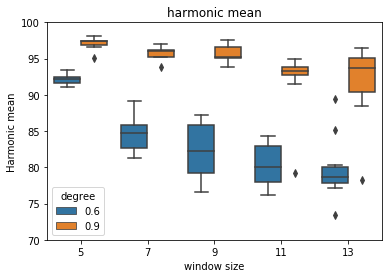

In [4]:
df_res=pd.DataFrame(res)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='Harmonic mean')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='Harmonic mean', hue="degree",data=b)
plt.ylim(70,100)
df_res_mean=pd.DataFrame(res_mean,index=['harmonic mean'])
print(df_res_mean)
plt.title('harmonic mean')
plt.savefig('harmonic_wsii_hurr.png')

              0.6                                                    0.9  \
               5          7          9          11         13         5    
purity  92.155918  84.546639  82.293497  80.266232  79.826619  97.111901   

                                                    
               7          9          11         13  
purity  95.763564  95.673014  91.965353  91.805124  


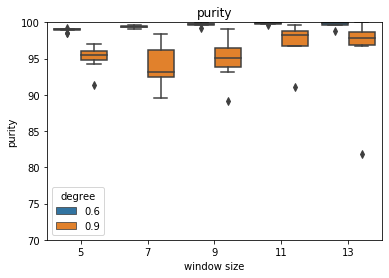

In [5]:
df_res=pd.DataFrame(pres)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='purity')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='purity', hue="degree",data=b)
plt.ylim(70,100)
df_res_mean=pd.DataFrame(res_mean,index=['purity'])
print(df_res_mean)
plt.title('purity')
plt.savefig('purity_wsii_hurr.png')

                0.6                                                    0.9  \
                 5          7          9          11         13         5    
coverage  92.155918  84.546639  82.293497  80.266232  79.826619  97.111901   

                                                      
                 7          9          11         13  
coverage  95.763564  95.673014  91.965353  91.805124  


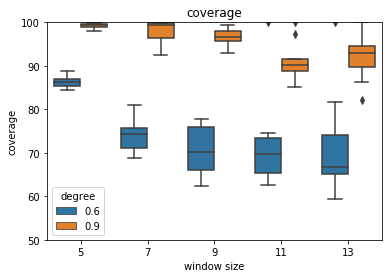

In [9]:
df_res=pd.DataFrame(cres)
b = df_res.unstack(level=0).reset_index(level=2, drop=True).reset_index(name='coverage')
b.rename(columns={'level_0':'degree','level_1':'window size'}, inplace=True)
import seaborn as sns
ax = sns.boxplot(x='window size', y='coverage', hue="degree",data=b)
plt.ylim(50,100)
df_res_mean=pd.DataFrame(res_mean,index=['coverage'])
print(df_res_mean)
plt.title('coverage')
plt.savefig('coverage_wsii_hur.png')

In [7]:
s=0
u=[]
ts=0
for l in listoffiles:
    df=read_fold(file_name=l,new_columns_names={'latitude': 'lat','longitude': 'lon'})
    #print(l,df.shape[0])
    ks=0
    for k,v in df.groupby(['tsid']):
        #print(k,v.shape[0])
        ks=ks+1
    s=s+df.shape[0]
    u.append([ks])
    ts=ts+ks
print("number of trajectory points:",s,"segments in each fold:",u,"Number of segments:",ts)

number of trajectory points: 1990 segments in each fold: [[20], [24], [15], [17], [15], [19], [17], [21], [15], [19]] Number of segments: 182
